<a href="https://colab.research.google.com/github/JaganFoundr/PyTorchNN/blob/main/Improved%20CNN/ImprovedCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
#1
import torch
from torchvision.datasets import CIFAR10
import torchvision.transforms as tt
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import SubsetRandomSampler, DataLoader
import torch.nn as nn
import torch.nn.functional as F

In [49]:
#2 Applying data normalization and data augmentation
statistic=((0.4914, 0.4822, 0.4465),(0.2023, 0.1994, 0.2010)) #mean and std deviation
train_transform = tt.Compose([tt.RandomCrop(size=32, padding=4, padding_mode='reflect'),
                        tt.RandomHorizontalFlip(),
                        tt.ToTensor(),
                        tt.Normalize(*statistic)]) # normalizing and augmenting the training set

test_transform = tt.Compose([tt.ToTensor(),
                             tt.Normalize(*statistic)]) #normalising the test set

# downloading the datasets and applying the transforms (for a moment training set is completely taken for training without
#splitting and testset is taken for validation and also for testing.
dataset=CIFAR10(root='./data', download=True, train=True, transform=train_transform)
validation_testset=CIFAR10(root='./data', download=True, train=False, transform=test_transform)
len(dataset)

Files already downloaded and verified
Files already downloaded and verified


50000

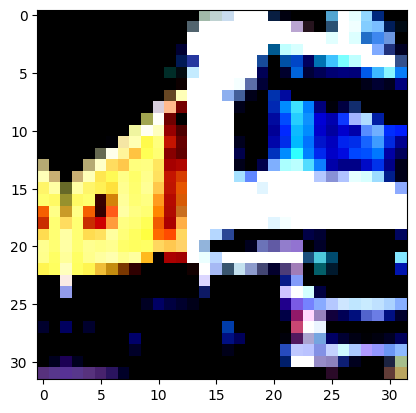

object number:  9
object name:  truck


In [50]:
#3
images, labels = dataset[1]
rgb_images=images.permute(1,2,0).numpy()
objectname=dataset.classes[labels]
plt.imshow(rgb_images)
plt.show()
print("object number: ", labels)
print("object name: ", objectname)

In [51]:
images.shape

torch.Size([3, 32, 32])

In [52]:
#4
batch_size=100

#num_workers are used to leverage multiple cpu cores and loading the images in parallel
#pin_memory avoids repeated allocation and deallocation of memory by using the same portion of memory(RAM) for loading each batch of data
#this is possible only because all of our images are 32x32 pixels
training_loader=DataLoader(dataset, batch_size,shuffle=True, num_workers=2, pin_memory=True)
validation_loader=DataLoader(validation_testset, batch_size, shuffle=False, num_workers=2, pin_memory=True)
print(len(training_loader.dataset))  # For training dataset
print(len(validation_loader.dataset))  # For test dataset


50000
10000


In [53]:
#5
#defining the model, here we are gonna use a larger model, wideresnet22 having 22 convolutional layers, 1 key changes to our
# model is the addition of residual block in which the inputs get added back to the output feature map obtained by the passing
# of inputs through one or more convolutional layers
# also applying batch normalization after each convolutional layer to reduce loss and increase the accuracy very fast.

#conv2d function
def conv2d(inp, out, ks=3, stride=1):
  return nn.Conv2d(in_channels=inp,
                   out_channels=out,
                   kernel_size=ks,
                   stride=stride,
                   padding=ks//2,
                   bias=False)

# the order we need to follow is apply batchnormalization, relu function, conv2d layer
def batch_relu_conv2d(inp, out):
  return nn.Sequential(nn.BatchNorm2d(inp),
                       nn.ReLU(inplace=True),
                       conv2d(inp,out))

#things happening inside a residual block
class ResidualBlock(nn.Module):
    def __init__(self, inp, out, stride=1):
        super().__init__()
        self.batchnorm = nn.BatchNorm2d(inp)
        self.conv1 = nn.Conv2d(inp, out, kernel_size=3, stride=stride, padding=1, bias=False)
        self.conv2 = batch_relu_conv2d(out, out)

        # Define shortcut branch
        if inp != out or stride != 1:
            # Match both channels and spatial dimensions
            self.shortcut = nn.Conv2d(inp, out, kernel_size=1, stride=stride, bias=False)
        else:
            self.shortcut = nn.Identity()  # No change if dimensions match exactly

    def forward(self, x):
        x = F.relu(self.batchnorm(x), inplace=True)
        r = self.shortcut(x)  # Ensure `r` matches dimensions of `x`
        x = self.conv1(x)
        x = self.conv2(x) * 0.2
        return x + r


#making groups / blocks
def make_blocks(N,inp, out, stride):
  start=ResidualBlock(inp, out, stride)
  rest = [ResidualBlock(out, out) for j in range(1,N)]
  return [start]+rest

#flattening class
class Flatten(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, x):
    return x.view(x.size(0),-1)

#wide resnet class
class WideResNet(nn.Module):
  def __init__(self, n_groups, N, n_classes, kernel=1, n_start=16):
    super().__init__()
    #increase channels to n_start using conv layer
    layers=[conv2d(3,n_start)]
    n_channels = [n_start]

    #add groups of basic blocks(increase channels and downsample)
    for i in range(n_groups):
      n_channels.append(n_start*(2**i)*kernel)
      stride=2 if i>0 else 1
      layers+=make_blocks(N, n_channels[i], n_channels[i+1], stride)

    #pool, flatten and add linear layers for classification
    layers+=[nn.BatchNorm2d(n_channels[3]),
             nn.ReLU(),
             nn.AdaptiveAvgPool2d(1),
             nn.Flatten(),
             nn.Linear(n_channels[3], n_classes)]

    self.features = nn.Sequential(*layers)

  def forward(self, x):
    return self.features(x)

def wrn_22():
    return WideResNet(n_groups=3,N=3,n_classes=10,kernel=6)

model = wrn_22()

In [54]:
#6
for images, labels in training_loader:
  prediction = model(images)

In [55]:
print("images shape: ",images.shape)
print("prediction shape: ",prediction.shape)

images shape:  torch.Size([100, 3, 32, 32])
prediction shape:  torch.Size([100, 10])


In [56]:
#7
print(prediction[10])

#8
sum_check=torch.sum(prediction[10])
print(sum_check)

changed_pred=F.softmax(prediction, dim=1)
print(torch.sum(changed_pred[10]))

print(changed_pred[10])

tensor([-0.3782, -0.4700, -0.1439,  0.1181, -0.1610, -0.1549,  0.4803, -0.2288,
         0.2264, -0.0038], grad_fn=<SelectBackward0>)
tensor(-0.7156, grad_fn=<SumBackward0>)
tensor(1., grad_fn=<SumBackward0>)
tensor([0.0708, 0.0646, 0.0895, 0.1164, 0.0880, 0.0886, 0.1671, 0.0823, 0.1297,
        0.1030], grad_fn=<SelectBackward0>)


In [57]:
#9
_, pred = torch.max(prediction, dim=1)
print(pred)


tensor([3, 6, 6, 8, 3, 7, 3, 3, 6, 9, 6, 9, 8, 3, 8, 9, 9, 3, 6, 9, 6, 9, 8, 8,
        3, 8, 6, 9, 8, 2, 9, 9, 9, 8, 6, 8, 9, 9, 6, 8, 9, 8, 9, 8, 3, 8, 9, 6,
        2, 9, 8, 2, 8, 6, 6, 9, 8, 9, 9, 8, 9, 8, 8, 9, 6, 6, 8, 3, 6, 9, 9, 6,
        6, 9, 9, 6, 8, 6, 8, 2, 6, 8, 9, 8, 6, 6, 6, 8, 6, 3, 9, 8, 9, 6, 8, 6,
        6, 9, 9, 6])


In [58]:
#10
labels

tensor([3, 2, 8, 1, 8, 0, 3, 0, 8, 3, 0, 7, 7, 7, 5, 8, 1, 4, 5, 1, 8, 7, 8, 5,
        4, 0, 9, 1, 3, 1, 3, 6, 1, 6, 5, 2, 5, 5, 9, 7, 4, 7, 0, 1, 1, 6, 0, 1,
        4, 2, 4, 6, 2, 9, 6, 5, 9, 7, 4, 1, 7, 9, 3, 6, 4, 5, 8, 1, 1, 7, 6, 9,
        4, 4, 3, 1, 5, 4, 4, 5, 3, 4, 9, 0, 7, 6, 3, 9, 7, 0, 3, 4, 9, 9, 9, 6,
        5, 9, 7, 0])

In [59]:
#11
loss_fn=F.cross_entropy



#12
opt=torch.optim.Adam(model.parameters(), lr=0.005)



#13
def accuracy(outputs, labels):
  _,pred=torch.max(outputs, dim=1)
  return torch.sum(pred==labels).item()/len(pred)*100

In [60]:
#14
def loss_batch(model, loss_fn, images, labels, opt, metrics=accuracy):
  prediction=model(images)
  loss=loss_fn(prediction, labels)

  if opt is not None:
    loss.backward()
    opt.step()
    opt.zero_grad()

  metric_result=None
  if metrics is not None:
    metric_result=metrics(prediction, labels)

  return loss.item(), len(images), metric_result

In [61]:
#15
def evaluate(model, loss_fn, validation_loader, metrics=accuracy):
  with torch.no_grad():
    validation_result=[loss_batch(model, loss_fn, images, labels, opt=None, metrics=accuracy) for images, labels in validation_loader]

    losses, nums, metric = zip(*validation_result)

    total = np.sum(nums)

    avg_loss = np.sum(np.multiply(losses, nums))/total

    metric_result=None
    if metrics is not None:
      metric_result = np.sum(np.multiply(metric, nums))/total

  return avg_loss, total, metric_result

In [62]:
#16
def train(nepochs, model, loss_fn, training_loader, validation_loader, opt, metrics=accuracy):
    # Initialize lists to store metrics for plotting
    train_losses, valid_losses = [], []
    train_accuracies, valid_accuracies = [], []

    for epoch in range(nepochs):
        # Training phase
        model.train()
        epoch_train_loss, epoch_train_acc = 0, 0
        for images, labels in training_loader:
            train_loss, _, train_acc = loss_batch(model, loss_fn, images, labels, opt, metrics)
            epoch_train_loss += train_loss
            epoch_train_acc += train_acc

        # Average training loss and accuracy
        train_losses.append(epoch_train_loss / len(training_loader))
        train_accuracies.append(epoch_train_acc / len(training_loader))

        # Validation phase
        model.eval()
        valid_loss, _, valid_acc = evaluate(model, loss_fn, validation_loader, metrics)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_acc)

        # Print metrics for the current epoch
        print(f"Epoch {epoch + 1}/{nepochs}")
        print(f"Training Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}")
        print(f"Training Accuracy: {train_acc:.2f}%, Validation Accuracy: {valid_acc:.2f}%")

    # Return all metrics for plotting
    return train_losses, valid_losses, train_accuracies, valid_accuracies

Epoch 1/6
Training Loss: 1.3742, Validation Loss: 1.4131
Training Accuracy: 51.00%, Validation Accuracy: 47.03%
Epoch 2/6
Training Loss: 0.9452, Validation Loss: 0.9774
Training Accuracy: 66.00%, Validation Accuracy: 65.04%
Epoch 3/6
Training Loss: 0.7298, Validation Loss: 0.8467
Training Accuracy: 76.00%, Validation Accuracy: 69.83%
Epoch 4/6
Training Loss: 0.6815, Validation Loss: 0.8314
Training Accuracy: 76.00%, Validation Accuracy: 71.23%
Epoch 5/6
Training Loss: 0.7275, Validation Loss: 0.6733
Training Accuracy: 74.00%, Validation Accuracy: 77.50%
Epoch 6/6
Training Loss: 0.6055, Validation Loss: 0.5650
Training Accuracy: 80.00%, Validation Accuracy: 80.23%


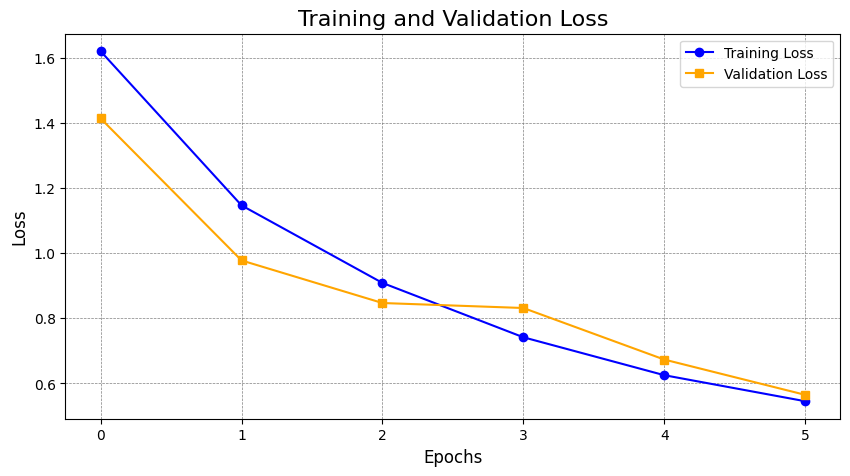

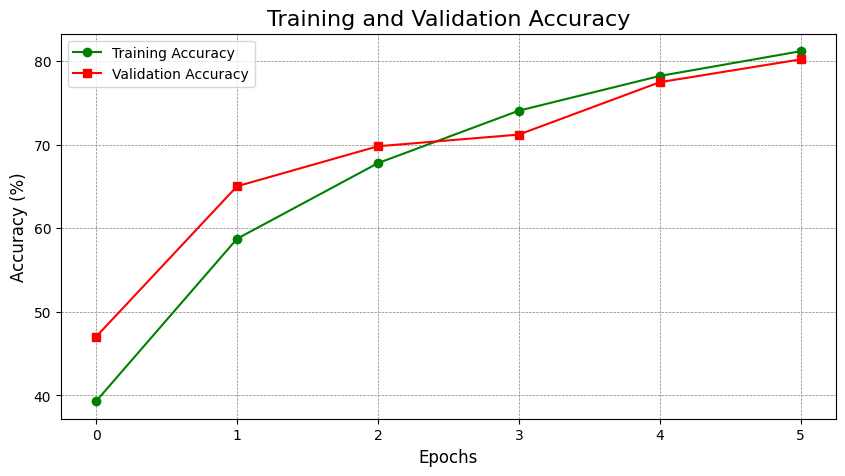

In [63]:
# Call the train function
train_losses, valid_losses, train_accuracies, valid_accuracies = train(
    6, model, loss_fn, training_loader, validation_loader, opt, metrics=accuracy
)

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss', color='blue', marker='o')
plt.plot(valid_losses, label='Validation Loss', color='orange', marker='s')
plt.title('Training and Validation Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy', color='green', marker='o')
plt.plot(valid_accuracies, label='Validation Accuracy', color='red', marker='s')
plt.title('Training and Validation Accuracy', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.legend()
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.show()

In [64]:
#17
def prediction(images, model):
  images = images.unsqueeze(0)
  prediction = model(images)
  _, pred = torch.max(prediction, dim=1)
  return pred[0].item()

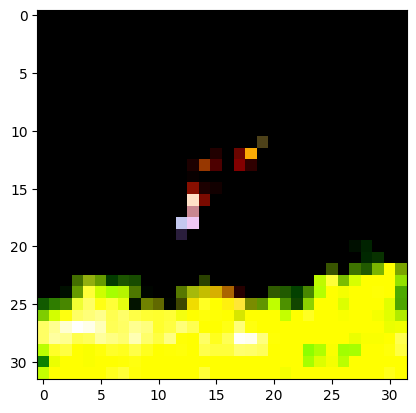

object name:  deer
predicted:  deer
Test loss is 0.5650 and Test accuracy is 80.23%


In [65]:
#18
images, labels = validation_testset[1801]
objectname=dataset.classes[labels]
rgb_images=images.permute(1,2,0).numpy()
plt.imshow(rgb_images)
plt.show()
print("object name: ",objectname)
print("predicted: ",dataset.classes[prediction(images,model)])


#testdata accuracy
test_loader=DataLoader(validation_testset, batch_size=200)
test_loss, _, test_acc=evaluate(model, loss_fn, test_loader, metrics=accuracy)
print(f"Test loss is {test_loss:.4f} and Test accuracy is {test_acc:.2f}%")


In [66]:
#19
torch.save(model.state_dict(),'CIFAR.pth')
model.state_dict()


saved_model=WideResNet(n_groups=3,N=3,n_classes=10,kernel=6)
saved_model.load_state_dict(torch.load('CIFAR.pth'))


<ipython-input-66-7a0aa8117a5a>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_model.load_state_dict(torch.load('CIFAR.pth'))


<All keys matched successfully>